In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gp

In [2]:
def multivariate_normal(n: int = 1000):
    mean=np.array([0,0])
    cov = np.array([[1, 0.5], [0.5, 1.75]])
    X = np.random.multivariate_normal(mean=mean, cov=cov, size=n)

    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    mins -= 0.1
    maxs += 0.1

    x = np.linspace(mins[0], maxs[0], 100)
    y = np.linspace(mins[1], maxs[1], 100)
    xx, yy = np.meshgrid(x, y)

    mean_hat = X.mean(axis=0)
    cov_hat = np.cov(X.T)

    dim = X.shape[1]
    def kernel(x):
        func = lambda x: np.exp(-0.5 * (x-mean_hat).T@np.linalg.inv(cov_hat)@(x-mean_hat)) / (np.sqrt((2*np.pi)**dim * np.linalg.det(cov_hat)))
        return np.array([func(t) for t in x])


    # # kernel = scipy.stats.gaussian_kde(X.T, bw_method="scott")
    xy = np.vstack([xx.ravel(), yy.ravel()])
    densities = kernel(xy.T).reshape(xx.shape)
    # plt.scatter(X[:, 0], X[:, 1])
    plt.contour(xx, yy, densities, levels=5)
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(xx, yy, densities, cmap="viridis", edgecolor="none")
    plt.show()

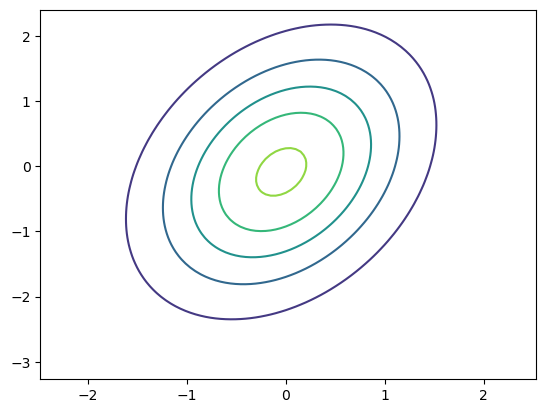

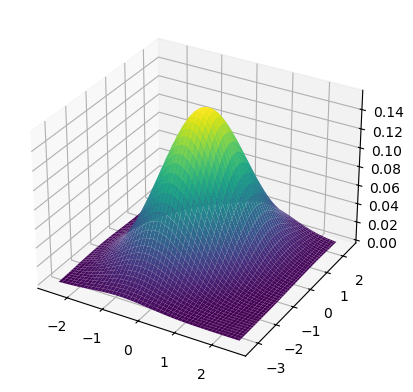

In [3]:
multivariate_normal(100)

/home/malick/Desktop/machine-learning-grind/01-machine-learning/01-stats/06-gaussian-process/gp.py:32: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = np.random.multivariate_normal(mean=mean, cov=cov, size=num_samples)


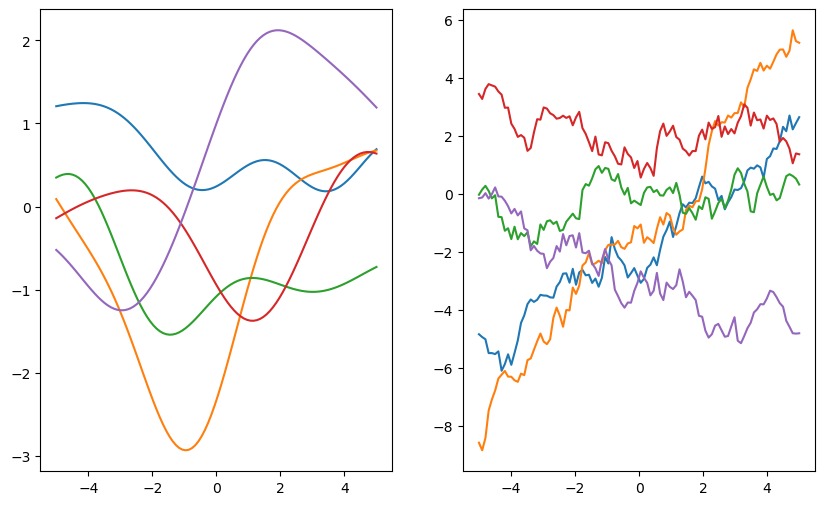

In [4]:
fig, axes = plt.subplots(1,2, figsize=(10,6))
axes = axes.ravel()
cov_functions = [gp.squared_exp(sigma=1, l=2), gp.brownian()]
for i, func in enumerate(cov_functions):
    gaussian_process = gp.GaussianProcess(
        mu=lambda x: 0., k=func
    )
    gaussian_process.represent_prior(ax=axes[i])
plt.show()

In [5]:
target = lambda x : x ** 2 * np.exp(- np.abs(x)/3.)
f = np.vectorize(target)

def gaussian_process_regression(axes, num_observations=5, num_samples=3, noise_data=0, kernel=gp.squared_exp(sigma=1, l=1), color=None):
    Xo = np.random.uniform(-5,5,num_observations)
    Yo = f(Xo) + np.random.normal(0., noise_data, Xo.shape[0])
    Xp = np.linspace(-5,5,100)

    gaussian_process = gp.GaussianProcess(
        mu=lambda x: 0.,
        k=kernel,
    )
    gaussian_process.represent_prior(ax=axes[0], num_samples=num_samples, color=color)

    mu, cov = gaussian_process.get_posterior(Xp=Xp, Xo=Xo, Yo=Yo)
    y = np.random.multivariate_normal(mean=mu, cov=cov, size=num_samples)
    for i in range(num_samples):
        axes[1].plot(Xp, y[i,:], color=color)
    axes[1].plot(Xo, Yo, 'x', markeredgecolor=color,  markeredgewidth=2, markersize=10)
    std = np.sqrt(np.diag(cov))  # Extract standard deviation
    axes[1].fill_between(Xp, mu - 2 * std, mu + 2 * std, color='gray', alpha=0.3, linewidth=0.1)  # Shaded region
    axes[1].plot(Xp, mu, 'k', lw=1)  # Plot mean
    axes[0].set_title(f"{num_samples} samples")
    axes[1].set_title(f"{num_observations} observations")


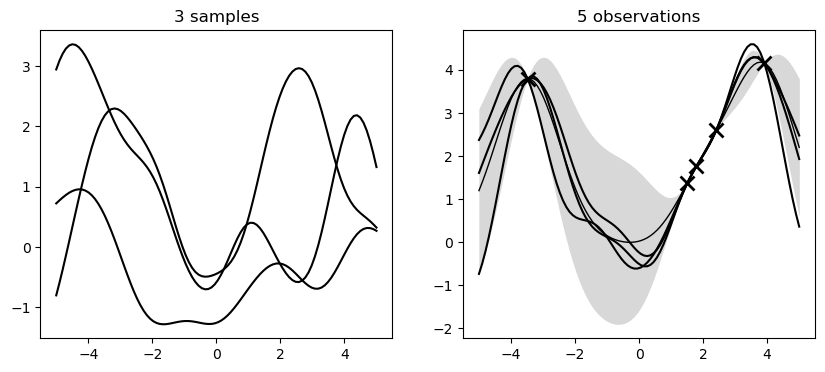

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
gaussian_process_regression(axes=axes, num_observations=5, num_samples=3, noise_data=0., kernel=gp.squared_exp(sigma=1, l=1), color="black")
plt.show()
# plt.savefig("gp-regression.png")

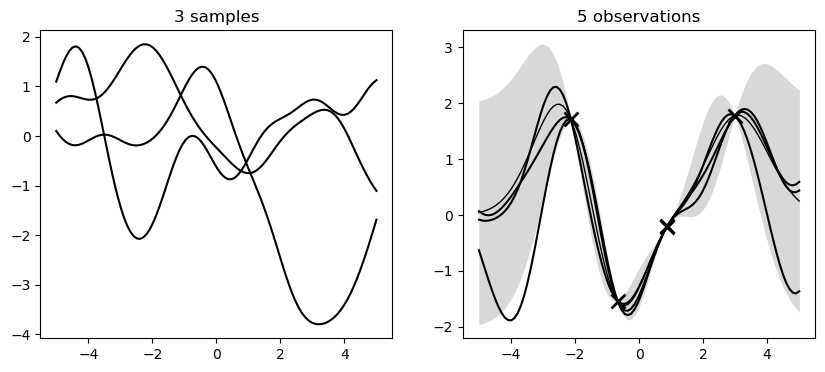

In [7]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
gaussian_process_regression(axes=axes, num_observations=5, num_samples=3, noise_data=1, kernel=gp.squared_exp(sigma=1, l=1), color="black")
plt.show()

/tmp/ipykernel_66956/2032226369.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = np.random.multivariate_normal(mean=mu, cov=cov, size=num_samples)
/tmp/ipykernel_66956/2032226369.py:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov))  # Extract standard deviation


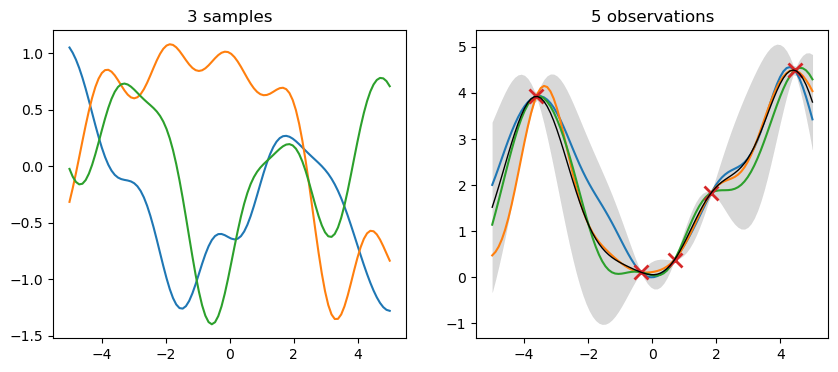

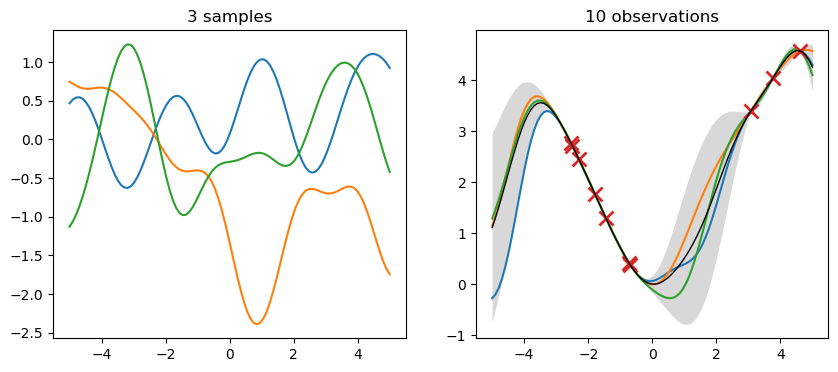

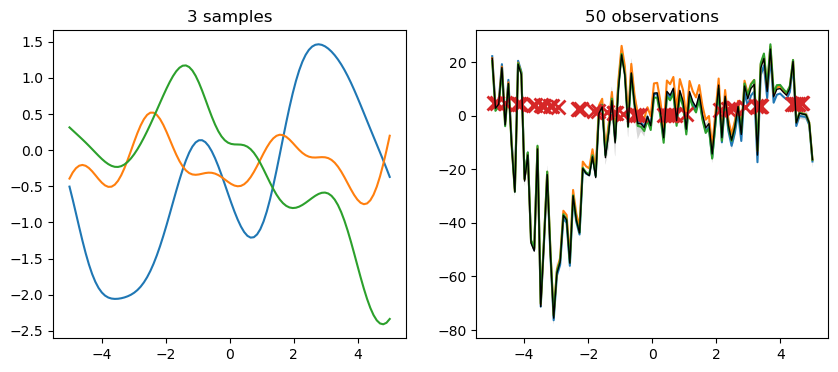

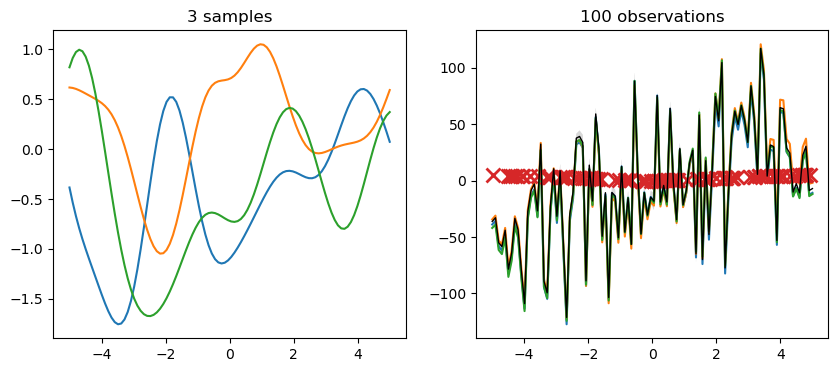

In [8]:
for i, n in enumerate([5, 10, 50, 100]):
    fig, axes = plt.subplots(1,2, figsize=(10,4))
    gaussian_process_regression(axes=axes, num_observations=n, num_samples=3, noise_data=0., kernel=gp.squared_exp(sigma=1, l=1))
plt.show()

Gaussian Process regression becomes unstable with 100 observations due to numerical issues in the covariance matrix inversion.

In [9]:
target = lambda x : x ** 2 * np.exp(- np.abs(x)/3.)
f = np.vectorize(target)

def gaussian_process_regression_white_noise(axes, num_observations=5, num_samples=3, noise_data=0, white_noise=0.1, kernel=gp.squared_exp(sigma=1, l=1), color=None):
    Xo = np.random.uniform(-5,5,num_observations)
    Yo = f(Xo) + np.random.normal(0., noise_data, Xo.shape[0])
    Xp = np.linspace(-5,5,100)

    white_noise_cov_func = lambda x,y: white_noise**2 if np.abs(x-y)<1e-8 else 0.
    gaussian_process = gp.GaussianProcess(
        mu=lambda x: 0.,
        k=kernel)

    gaussian_process.represent_prior(ax=axes[0], num_samples=num_samples, color=color)
    mu, cov = gaussian_process.get_posterior(Xp=Xp, Xo=Xo, Yo=Yo)
    y = np.random.multivariate_normal(mean=mu, cov=cov, size=num_samples)
    for i in range(num_samples):
        axes[1].plot(Xp, y[i,:], color=color)
    axes[1].plot(Xo, Yo, 'x', markeredgecolor=color,  markeredgewidth=2, markersize=10)
    std = np.sqrt(np.diag(cov))  # Extract standard deviation
    axes[1].fill_between(Xp, mu - 2 * std, mu + 2 * std, color='gray', alpha=0.3, linewidth=0.1)  # Shaded region
    axes[1].plot(Xp, mu, 'k', lw=1)  # Plot mean
    axes[0].set_title(f"{num_samples} samples")
    axes[1].set_title(f"{num_observations} observations")
    
    gaussian_process_with_noise = gp.GaussianProcess(
        mu=lambda x: 0.,
        k=lambda x,y: kernel(x,y) + white_noise_cov_func(x,y)
    )

    gaussian_process_with_noise.represent_prior(ax=axes[2], num_samples=num_samples, color=color)
    mu, cov = gaussian_process_with_noise.get_posterior(Xp=Xp, Xo=Xo, Yo=Yo)
    y = np.random.multivariate_normal(mean=mu, cov=cov, size=num_samples)
    for i in range(num_samples):
        axes[3].plot(Xp, y[i,:], color=color)
    axes[3].plot(Xo, Yo, 'x', markeredgecolor=color,  markeredgewidth=2, markersize=10)
    std = np.sqrt(np.diag(cov))  # Extract standard deviation
    axes[3].fill_between(Xp, mu - 2 * std, mu + 2 * std, color='gray', alpha=0.3, linewidth=0.1)  # Shaded region
    axes[3].plot(Xp, mu, 'k', lw=1)  # Plot mean
    axes[2].set_title(f"with noise - {num_samples} samples")
    axes[3].set_title(f"with noise - {num_observations} observations")


/tmp/ipykernel_66956/1314485640.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = np.random.multivariate_normal(mean=mu, cov=cov, size=num_samples)
/tmp/ipykernel_66956/1314485640.py:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov))  # Extract standard deviation


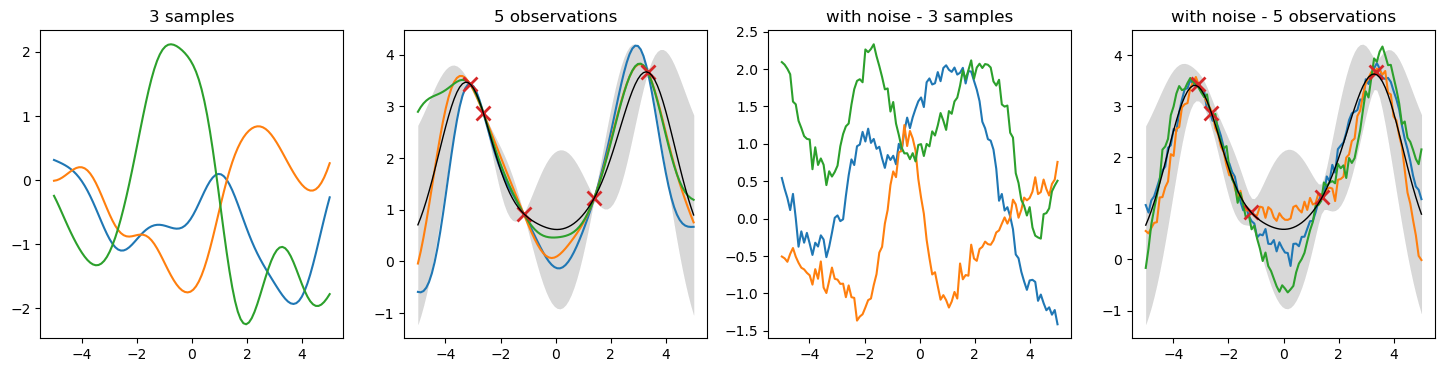

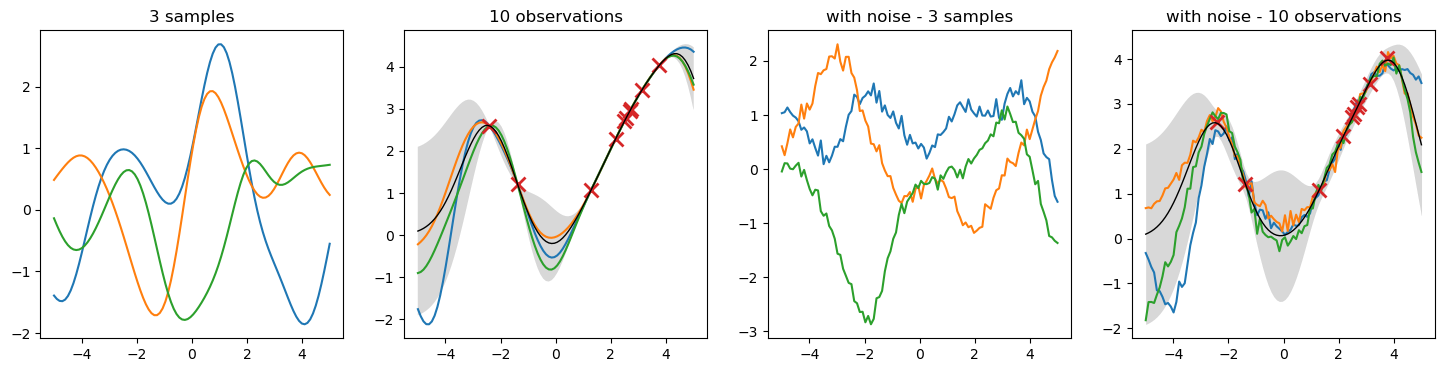

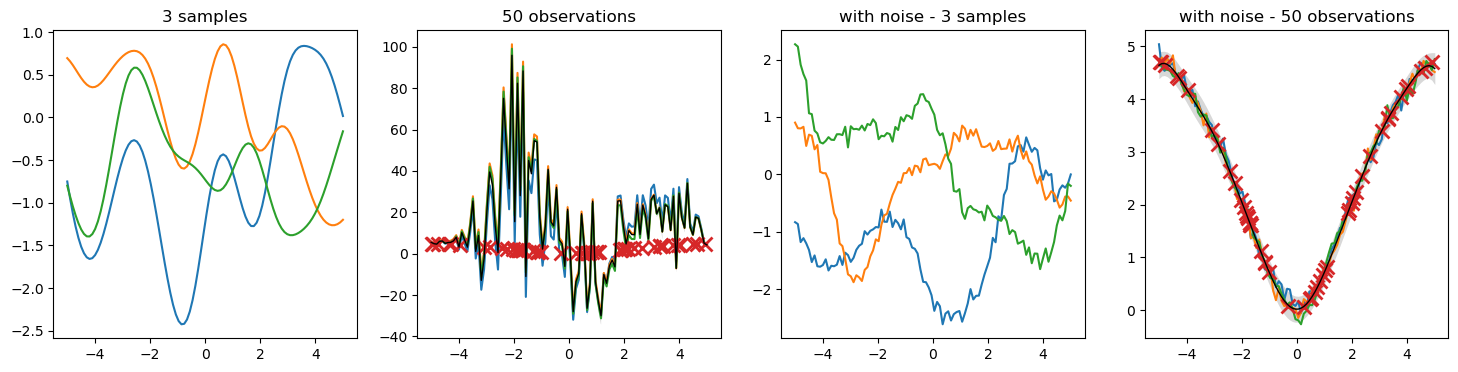

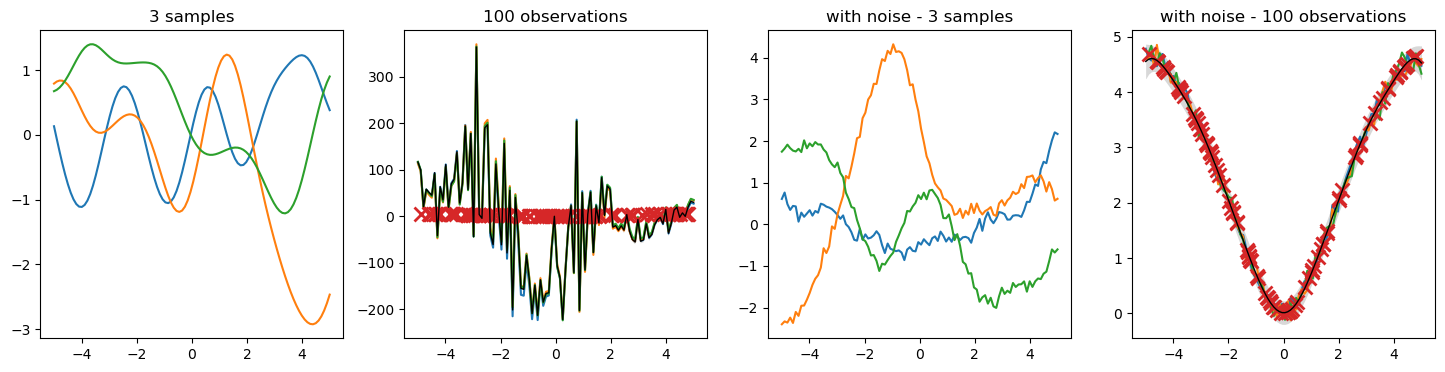

In [10]:
for i, n in enumerate([5, 10, 50, 100]):
    fig, axes = plt.subplots(1,4, figsize=(18,4))
    gaussian_process_regression_white_noise(axes=axes, num_observations=n, num_samples=3, noise_data=0., white_noise=0.1, kernel=gp.squared_exp(sigma=1, l=1))
plt.show()

/tmp/ipykernel_66956/1314485640.py:16: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y = np.random.multivariate_normal(mean=mu, cov=cov, size=num_samples)
/tmp/ipykernel_66956/1314485640.py:20: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(np.diag(cov))  # Extract standard deviation


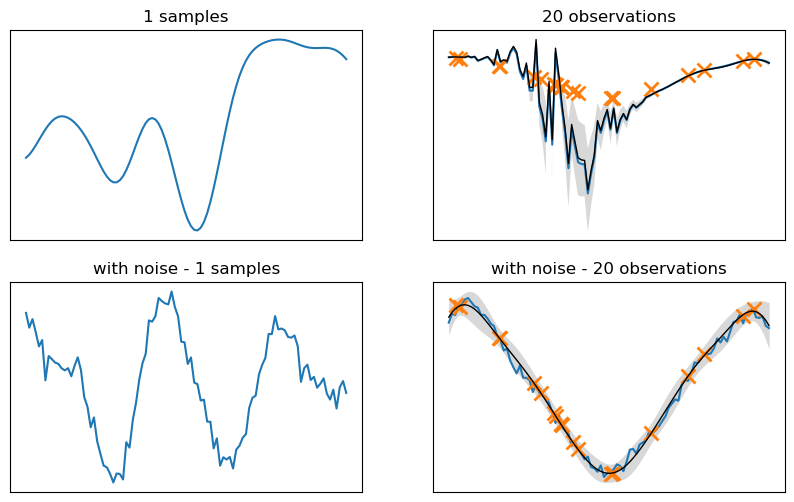

In [29]:
fig, axes = plt.subplots(2,2, figsize=(10,6))
axes = axes.ravel()
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
gaussian_process_regression_white_noise(axes=axes, num_observations=20, num_samples=1, noise_data=0., white_noise=0.1, kernel=gp.squared_exp(sigma=1, l=1))